## A3 method (ALS-WR)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import time
%matplotlib inline

##  Step1: Load Data and Train-test Split

In [2]:
DATA_PATH = "../data/ml-latest-small"
ratings = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv'))
ratings = ratings.loc[:, ["userId","movieId","rating"]]
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [3]:
np.random.seed(123)
test_index = np.random.choice(len(ratings), size= round(len(ratings)/5), replace=False)
train_index = np.setdiff1d(np.arange(len(ratings)), test_index)
ratings_train = ratings.iloc[train_index] 
ratings_test = ratings.iloc[test_index]

### Pre-Processing

In [4]:
# number of users and movies
n_users = len(np.unique(ratings["userId"]))
n_movies = len(np.unique(ratings["movieId"]))

In [ ]:
# Rating matrix for training data
R_train = pd.DataFrame(0, index=np.unique(ratings["userId"]), columns=np.unique(ratings["movieId"]))
for row in ratings_train.itertuples():
    R_train.loc[row[1], row[2]] = row[3]
R_train = R_train.to_numpy()
# Rating matrix for testing data
R_test = pd.DataFrame(0, index=np.unique(ratings["userId"]), columns=np.unique(ratings["movieId"]))
for row in ratings_test.itertuples():
    R_test.loc[row[1], row[2]] = row[3]
R_test = R_test.to_numpy()

In [7]:
# Selector matrix for training data
I_train = R_train.copy()
I_train[I_train>0] = 1
I_train[I_train==0] = 0
# Selector matrix for testing data
I_test = R_test.copy()
I_test[I_test>0] = 1
I_test[I_test==0] = 0

## Step2: Matrix Factorization

### Step 2.1 Algorithm and Regularization

In [8]:
# function to calculate RMSE
def RMSE(true, est, I):
    '''
    true: rating matrix observed
    est: rating matrix estimated
    I: selector matrix
    '''
    MSE = np.sum((I*(true - est))**2)/len(true[true>0])
    return np.sqrt(MSE)
    

In [9]:
# function to do alternate least squares
def ALS(train, test, lmbda, n_f, n_m, n_u, epoch, R, T, I, I1):
    '''
    train: train data
    test: test data
    lmbda: penalty
    n_f: number of latent features
    n_m: number of movies
    n_u: number of users
    epoch: number of iterations
    R: Rating matrix for training data
    T: Rating matrix for testing data
    I: Selector matrix for training data
    I1: Selector matrix for testing data
    return a dictinoary
    '''
    np.random.seed(123)
    # initialize matrix M: Latent movie feature matrix
    M = np.random.uniform(low=0, high=1, size=(n_f, n_m))
    ave_ratings = np.sum(R, axis=0)/np.where(np.count_nonzero(R, axis=0)!=0, np.count_nonzero(R, axis=0),1)
    M[0,:] = ave_ratings
    # initialize matrix U: Latent user feature matrix
    U = np.random.uniform(low=0, high=1, size=(n_f, n_u))
    E = np.identity(n_f)
    # initialize RMSE container
    rmse_train = []
    rmse_test = []
    
    for value in range(epoch):
        # solve matrix U when M is given
        for i, Ii in enumerate(I):
            n_ui = np.count_nonzero(Ii)
            if n_ui == 0: 
                n_ui = 1 
            Ii_index = np.nonzero(Ii)[0] 
            M_Ii = M[:, Ii_index]
            R_Ii = R[i, Ii_index]
            A_i = np.dot(M_Ii, np.transpose(M_Ii)) + lmbda * n_ui * E
            V_i = np.dot(M_Ii, np.transpose(R_Ii))
            u_i = np.dot(np.linalg.inv(A_i), V_i)
            U[:,i] = u_i
    
        # solve matrix M when U is given 
        for j, Ij in enumerate(np.transpose(I)):
            n_mj = np.count_nonzero(Ij)
            if n_mj == 0: 
                n_mj = 1 
            Ij_index = np.nonzero(Ij)[0]
            U_Ij = U[:, Ij_index]
            R_Ij = R[Ij_index, j]
            A_j = np.dot(U_Ij, np.transpose(U_Ij)) + lmbda *n_mj * E
            V_j = np.dot(U_Ij, R_Ij)
            m_j = np.dot(np.linalg.inv(A_j), V_j)
            M[:, j] = m_j
        
        # calculate RMSE
        est_rating = np.dot(np.transpose(U), M)
        rmse_train_cur = RMSE(R , est_rating, I)
        rmse_test_cur = RMSE(T, est_rating, I1)
        rmse_train.append(rmse_train_cur)
        rmse_test.append(rmse_test_cur)
        
    return {"U": U, "M":M, "Est_Rating":est_rating, "Train_RMSE": rmse_train, "Test_RMSE": rmse_test}   

### Step2.2:  Parameter Tuning (Cross Validation)

In [10]:
# function to do pre-processing for cross validation to reduce running time
def cross_validation_setup(train, K):
    '''
    train: train data
    K: number of folds
    return the pro-processing results for each split
    '''
    MATRIX = {key:None for key in range(K)}
    nfold = round(len(train)/K)
    catego = np.repeat(list(range(1,K+1)), [nfold]*(K-1)+ [n-(K-1)*nfold])
    np.random.seed(123)
    s = np.random.choice(catego, size=len(catego), replace=False)
    for j in range(1,K+1):
        data_train = train.loc[s!=j,:]
        data_test = train.loc[s==j,:]
        # Rating matrix for training data
        R_train = pd.DataFrame(0, index=np.unique(ratings["userId"]), columns=np.unique(ratings["movieId"]))
        for row in data_train.itertuples():
            R_train.loc[row[1], row[2]] = row[3]
        R_train = R_train.to_numpy()
        # Rating matrix for testing data
        R_test = pd.DataFrame(0, index=np.unique(ratings["userId"]), columns=np.unique(ratings["movieId"]))
        for row in data_test.itertuples():
            R_test.loc[row[1], row[2]] = row[3]
        R_test = R_test.to_numpy()
        # Selector matrix for training data
        I_train = R_train.copy()
        I_train[I_train>0] = 1
        I_train[I_train==0] = 0
        # Selector matrix for testing data
        I_test = R_test.copy()
        I_test[I_test>0] = 1
        I_test[I_test==0] = 0
        MATRIX[j-1] = {"train": data_train, "test": data_test, "R":R_train, 
                       "T":R_test, "I":I_train, "I1":I_test}
    return MATRIX
    

In [11]:
# function to do cross-validation
def cross_validation(K, n_f, lmbda, matrix):
    '''
    K: number of folds
    n_f: number of features
    lmbda: penalty
    matrix: the pro-processing results
    return the cv results for each parameter pair
    '''
    train_rmse = np.zeros((K,15))
    test_rmse = np.zeros((K,15))
    for j in range(0,K):
        para = matrix[j]
        # ALS
        result = ALS(n_f=n_f, lmbda=lmbda, n_m=n_movies, n_u=n_users, epoch=15, **para)
        train_rmse[j,] = result["Train_RMSE"]
        test_rmse[j,] = result["Test_RMSE"]
    return {"Train_RMSE":train_rmse.mean(axis=0), "Test_RMSE":test_rmse.mean(axis=0)}

In [ ]:
# pre-processing for cross validation
CV = cross_validation_setup(ratings_train, 5)
#pickle.dump(CV, open( "../output/CV.p", "wb" ))
#CV = pickle.load(open( "../output/CV.p", "rb" ))

In [12]:
# cross validation 
feature_list = [5,10,15,20,50]
lmbda_list = [0.05,0.10,0.15,0.2]
PARA = [[x,y] for x in feature_list for y in lmbda_list]
result_summary = {key:None for key in range(np.size(PARA, axis=0))}
for value in range(np.size(PARA, axis=0)):
    result_cur = cross_validation(K=5, n_f=PARA[value][0], lmbda=PARA[value][1], matrix=CV)
    result_summary[value] = result_cur
#pickle.dump(result_summary, open( "../output/CV_result.p", "wb" ))
#result_summary = pickle.load(open( "../output/CV_result.p", "rb" ))
testrmse = [result_summary[keys]["Test_RMSE"] for keys in result_summary]
testrmse_best = [x[-1] for x in testrmse]
best_index = testrmse_best.index(min(testrmse_best)) - 1
print("The best parameters are:\n")
print("lambda: %f" %PARA[best_index][1], "number of features: %i" %PARA[best_index][0], sep='\n')

The best parameters are:

lambda: 0.150000
number of features: 20


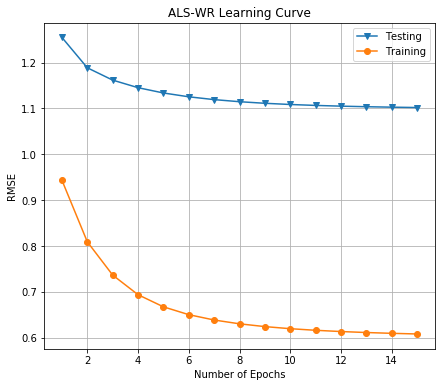

The train rmse of the optimal model is:0.6078982857152175
The test rmse of the optimal model is:1.1020754291448498
The training time is: 24.311256s


In [13]:
# visulize the learning curve of the best model
best_feature = PARA[best_index][0]
best_lmbda = PARA[best_index][1]
start_time = time.time()
best_model = ALS(train=ratings_train, test=ratings_test, n_f=best_feature, lmbda=best_lmbda, 
                 n_m=n_movies, n_u=n_users, epoch=15, R=R_train, T=R_test, I=I_train, I1=I_test)
plt.figure(figsize=(7,6))
plt.plot(range(1,16), best_model["Test_RMSE"], marker="v", label="Testing")
plt.plot(range(1,16), best_model["Train_RMSE"], marker="o", label="Training")
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
print("The train rmse of the optimal model is:{}".format(best_model["Train_RMSE"][-1]))
print("The test rmse of the optimal model is:{}".format(best_model["Test_RMSE"][-1]))
print("The training time is: %f" % (time.time() - start_time) + "s")

## Step3: Postprocessing

In [14]:
# function to calculate cosine similarity between two vectors
def cos_similarity(v1,v2):
    dot_product = np.dot(v1,v2)
    v1_norm = np.linalg.norm(v1)
    V2_norm = np.linalg.norm(v2)
    if v1_norm == 0.0 or V2_norm == 0.0:
        return 0
    else:
        return dot_product/ (v1_norm*V2_norm)

In [15]:
# function to calculate similarity between each test movie and train movie of user i
def similarity(i, train, test, M):
    similar = []
    index_train = np.nonzero(train[i,:])[0]
    index_test = np.nonzero(test[i,:])[0]
    for testidx in index_test:
        sim = dict()
        v1 = M[:,testidx]
        for trainidx in index_train:
            v2 = M[:,trainidx]
            s = cos_similarity(v1,v2)
            sim[trainidx] = s
        similar.append(sim)
    return similar


In [16]:
# get similarity for all the users
SIM = []
for i in range(n_users):
    sim = similarity(i,R_train,R_test,best_model['M'])
    SIM.append(sim)

In [17]:
# a functin to do knn
def KNN(K, train, test, M, SIM):
    n, m = test.shape
    R_predict = np.zeros((n,m))
    for i in range(n):
        sim = SIM[i]
        index_train = np.nonzero(train[i,:])[0]
        index_test = np.nonzero(test[i,:])[0]
        number = len(index_train)
        if number <= K:
            for j in range(len(sim)):
                s = sim[j]
                idx = index_test[j]
                weight = sorted(s.values(), reverse=True)
                v = sorted(s, key= lambda i: s[i], reverse=True)
                if np.sum(weight) == 0:
                    R_predict[i, idx] = np.mean(train[i,v])
                else:
                    R_predict[i, idx] = np.average(train[i,v], weights=weight)
        else:
            for j in range(len(sim)):
                s = sim[j]
                idx = index_test[j]
                weight = sorted(s.values(), reverse=True)[:K]
                v = sorted(s, key= lambda i: s[i], reverse=True)[:K]
                if np.sum(weight) == 0:
                    R_predict[i, idx] = np.mean(train[i,v])
                else:
                    R_predict[i, idx] = np.average(train[i,v], weights=weight)

    return R_predict 

In [18]:
# K=1
R_predict = KNN(1, R_train, R_test, best_model["M"], SIM)
print("The test rmse of the ajusted model when K=1 is:{}".format(RMSE(R_test , R_predict, I_test)))

The test rmse of the ajusted model when K=1 is:1.1043735770424155


The best K is:21
The lowest RMSE is:0.9156695936657337


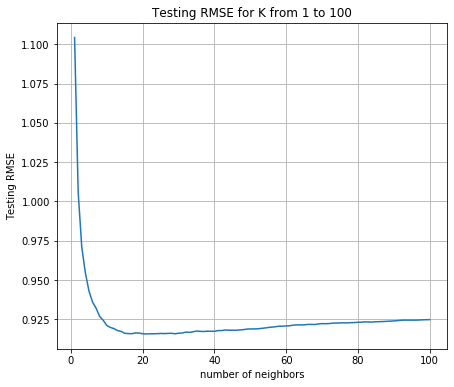

In [20]:
# choose the best K
K_num = range(1,101)
rmse_test = []
for i,k in enumerate(K_num):
    pred = KNN(k, R_train, R_test,best_model["M"], SIM)
    error = RMSE(R_test , pred, I_test)
    rmse_test.append(error)
plt.figure(figsize=(7,6))
plt.plot(K_num, rmse_test)
plt.xlabel("number of neighbors") 
plt.ylabel("Testing RMSE")
plt.title("Testing RMSE for K from 1 to 100")
plt.grid()
print("The best K is:{}".format(rmse_test.index(min(rmse_test))+1))
print("The lowest RMSE is:{}".format(min(rmse_test)))

## Step4: Evaluation

In [17]:
# fix number of features to be 20, change lambda
lmbdas = [0.04,0.06,0.08,0.10,0.12,0.15,0.2]
RESULTS = []
for value in lmbdas:
    result = ALS(train=ratings_train, test=ratings_test, n_f=20, lmbda=value, n_m=n_movies, 
             n_u=n_users, epoch=15, R=R_train, T=R_test, I=I_train, I1=I_test)
    RESULTS.append(result)

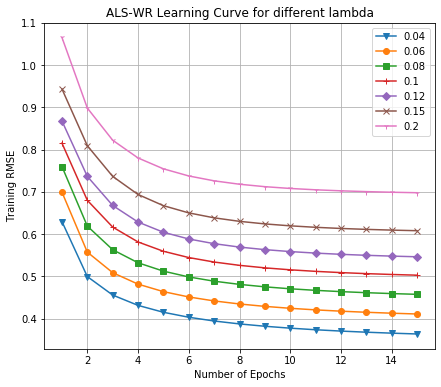

In [18]:
markers = ["v","o","s","+","D","x","1","3"]
plt.figure(figsize=(7,6))
for value in range(len(lmbdas)):
    plt.plot(range(1,16), RESULTS[value]["Train_RMSE"], marker=markers[value], label=lmbdas[value])
plt.title('ALS-WR Learning Curve for different lambda')
plt.xlabel('Number of Epochs')
plt.ylabel('Training RMSE')
plt.legend()
plt.grid()
plt.show()

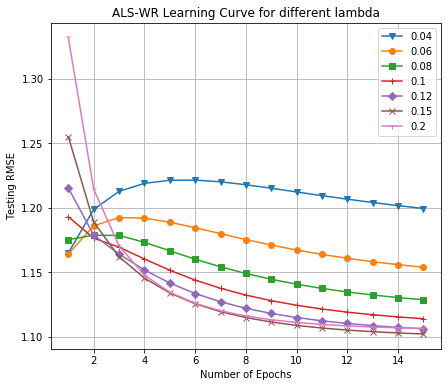

In [19]:
plt.figure(figsize=(7,6))
for value in range(len(lmbdas)):
    plt.plot(range(1,16), RESULTS[value]["Test_RMSE"], marker=markers[value], label=lmbdas[value])
plt.title('ALS-WR Learning Curve for different lambda')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing RMSE')
plt.legend()
plt.grid()
plt.show()

In [20]:
# fix lambda to be 0.15, change number of features
feature = [5,10,15,20,50,100]
RESULTS = []
for value in feature:
    result = ALS(train=ratings_train, test=ratings_test, n_f=value, lmbda=0.15, n_m=n_movies, 
             n_u=n_users, epoch=15, R=R_train, T=R_test, I=I_train, I1=I_test)
    RESULTS.append(result)  

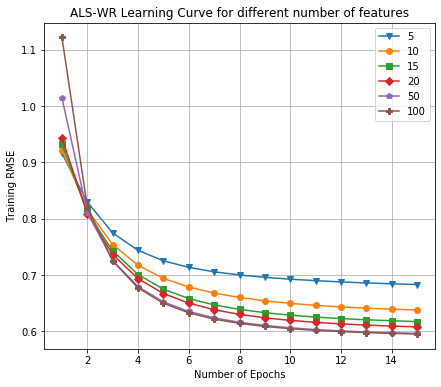

In [21]:
markers = ["v","o","s","D","p","P"]
plt.figure(figsize=(7,6))
for value in range(len(feature)):
    plt.plot(range(1,16), RESULTS[value]["Train_RMSE"], marker=markers[value], label=feature[value])
plt.title('ALS-WR Learning Curve for different number of features')
plt.xlabel('Number of Epochs')
plt.ylabel('Training RMSE')
plt.legend()
plt.grid()
plt.show()

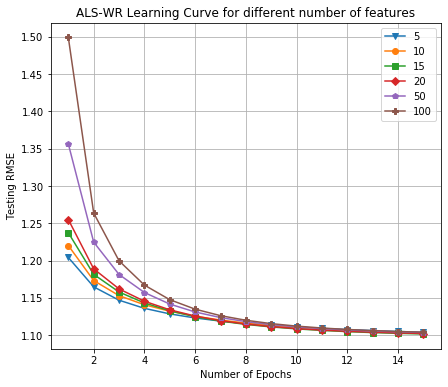

In [22]:
plt.figure(figsize=(7,6))
for value in range(len(feature)):
    plt.plot(range(1,16), RESULTS[value]["Test_RMSE"], marker=markers[value], label=feature[value])
plt.title('ALS-WR Learning Curve for different number of features')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing RMSE')
plt.legend()
plt.grid()
plt.show()

## A2 method: PMF

## Step 1 Load Data and Train-test Split

In [1]:
import numpy as np
from numpy import *
import random


def load_rating_data(file_path="../data/ml-latest-small/ratings.csv"):
    """
    load movie lens 100k ratings from original rating file.
    need to download and put rating data in /data folder first.
    Source: http://www.grouplens.org/
    """
    prefer = []
    for line in open(file_path, 'r'):  # 打开指定文件
        (userid, movieid, rating, ts) = line.split(',')  # 数据集中每行有4项
        if(userid=="userId"): continue
        uid = int(userid)
        mid = int(movieid)
        rat = float(rating)
        prefer.append([uid, mid, rat])
    data = array(prefer)
    return data

In [4]:
data=load_rating_data("data/ml-latest-small/ratings.csv")
data

array([[1.00000e+00, 1.00000e+00, 4.00000e+00],
       [1.00000e+00, 3.00000e+00, 4.00000e+00],
       [1.00000e+00, 6.00000e+00, 4.00000e+00],
       ...,
       [6.10000e+02, 1.68250e+05, 5.00000e+00],
       [6.10000e+02, 1.68252e+05, 5.00000e+00],
       [6.10000e+02, 1.70875e+05, 3.00000e+00]])

In [5]:
np.shape(data)

(100836, 3)

In [7]:
## reindex the movie id
new_data = data[data[:,1].argsort()]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(new_data[:, 1])
a=le.transform(new_data[:, 1])
c=np.array(a).reshape(100836,1)Step2 Matrix Factorization (probabilistic-matrix-factorization)

In [8]:
final_data = np.concatenate((new_data,c),axis=1)
final_data=final_data[:,[0,3,2]]

In [10]:
## split dataset
from sklearn.model_selection import train_test_split
random.seed(123)
train, test = train_test_split(final_data)

## Step2 Matrix Factorization (probabilistic-matrix-factorization)

In [11]:
import numpy as np

class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda1=0.1,_lambda2=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  
        self.epsilon = epsilon  
        self._lambda1 = _lambda1  
        self._lambda2 = _lambda2  
        self.momentum = momentum  
        self.maxepoch = maxepoch  
        self.num_batches = num_batches  
        self.batch_size = batch_size  

        self.w_Movie = None  # matrix for movie
        self.w_User = None  # matrix for user

        self.rmse_train = []
        self.rmse_test = []

    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    
    def fit(self, train_vec, test_vec):
        
        self.mean_inv = np.mean(train_vec[:, 2])  # rating mean

        pairs_train = train_vec.shape[0]  # the number of lines in traindata 
        pairs_test = test_vec.shape[0]  # the number of lines in testdata

        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # the total number of user
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # the total number of movie

        incremental = False  
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Movie = 0.1 * np.random.randn(num_item, self.num_feat)  # numpy.random.randn movie: M x D normal-distributed-matrix
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # numpy.random.randn user: N x D normal-distributed-matrix

            self.w_Movie_inc = np.zeros((num_item, self.num_feat))  # movie: M x D 0-matrix
            self.w_User_inc = np.zeros((num_user, self.num_feat))  # user: N x D 0-matrix

        while self.epoch < self.maxepoch:  # check the number of iterations
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  

            # Batch update
            for batch in range(self.num_batches):  
                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_MovieID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Movie[batch_MovieID, :]),
                                  axis=1)  

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Movie[batch_MovieID, :]) \
                       + self._lambda1 * self.w_User[batch_UserID, :]
                Ix_Movie = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda2 * (self.w_Movie[batch_MovieID, :])  # np.newaxis :increase the dimension

                dw_Movie = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Movie[batch_MovieID[i], :] += Ix_Movie[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Movie_inc = self.momentum * self.w_Movie_inc + self.epsilon * dw_Movie / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Movie = self.w_Movie - self.w_Movie_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Movie[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  
                    rawErr = pred_out - train_vec[:, 2]
                    obj = 0.5*np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda1 * np.linalg.norm(self.w_User) ** 2 + 0.5 * self._lambda2 * np.linalg.norm(self.w_Movie) ** 2

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Movie[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)
                    rawErr = pred_out - test_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    #if batch == self.num_batches - 1:
                        #print('Training RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self):
        return np.dot(self.w_Movie, self.w_User)

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda1 = parameters.get("_lambda1", 0.1)
            self._lambda2 = parameters.get("_lambda2", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

## Step 2.2 Tuning Parameter

In [12]:
## list of parameters
num_feat_list=np.arange(10,40,10)
lambda1_list=np.array([0.05,0.1,0.2])
lambda2_list=np.array([0.05,0.1,0.2])

In [14]:
pmf=PMF()
K=5
n=len(train)
for i in num_feat_list:
    for j in lambda1_list:
        for z in lambda2_list:
            pmf.set_params({"num_feat": i, "epsilon": 1, "_lambda": j, "_lambda2": z,"momentum": 0.8, "maxepoch": 100, "num_batches": 10,
                    "batch_size": 1000})
            print('num_latent =',i,'lambda for user =',j,'lambda for movie =',z)
            nfold = round(len(train)/K)
            catego = np.repeat(list(range(1,K+1)), [nfold]*(K-1)+ [n-(K-1)*nfold])
            np.random.seed(1)
            s = np.random.choice(catego, size=len(catego), replace=False)
            for k in range(1,K+1):
                X_train = train[s!=k,:]
                X_test = train[s==k,:]
                train_error=[]
                test_error=[]
                pmf.fit(X_train, X_test)
            train_error.append(pmf.rmse_train[-100:])
            test_error.append(pmf.rmse_test[-100:])
            RMSE_train=np.mean(train_error,axis=0)
            RMSE_test=np.mean(test_error,axis=0)
            print('For Training DataSet',RMSE_train[-1])
            print('For Testing DataSet',RMSE_test[-1])
            #fig, axs = plt.subplots(1,2)
            #plt.subplots_adjust(wspace =0.5, hspace =0)
            #axs[0].plot(range(pmf.maxepoch), RMSE_train, marker='o', label='Training Data',color='#6A5ACD')
            #axs[1].plot(range(pmf.maxepoch), RMSE_test, marker='v', label='Test Data',color='#FFA500')
            #plt.xlabel('Number of Epochs')
            #plt.ylabel('RMSE')
            #axs[0].legend(loc = 3)
            #axs[1].legend(loc = 3)
            #axs[0].grid()
            #axs[1].grid()
            #plt.show()

num_latent = 10 lambda for user = 0.05 lambda for movie = 0.05
For Training DataSet 0.535270611984319
For Testing DataSet 1.2108615481602454
num_latent = 10 lambda for user = 0.05 lambda for movie = 0.1
For Training DataSet 0.540019120574478
For Testing DataSet 1.207181832435016
num_latent = 10 lambda for user = 0.05 lambda for movie = 0.2
For Training DataSet 0.5498532950466861
For Testing DataSet 1.2019759305605786
num_latent = 10 lambda for user = 0.1 lambda for movie = 0.05
For Training DataSet 0.535270611984319
For Testing DataSet 1.2108615481602454
num_latent = 10 lambda for user = 0.1 lambda for movie = 0.1
For Training DataSet 0.540019120574478
For Testing DataSet 1.207181832435016
num_latent = 10 lambda for user = 0.1 lambda for movie = 0.2
For Training DataSet 0.5498532950466861
For Testing DataSet 1.2019759305605786
num_latent = 10 lambda for user = 0.2 lambda for movie = 0.05
For Training DataSet 0.535270611984319
For Testing DataSet 1.2108615481602454
num_latent = 10 lambd

After tuning parameter we choose the number of latent variables as 30 and _lambda for user = 0.1 and _lambda for movie = 0.2

The number of Latent Factors: 30 The lambda for User: 0.1 The lambda for Movie: 0.2
RMSE for Train 0.537958430544599
RMSE for Test 1.1625708116046378


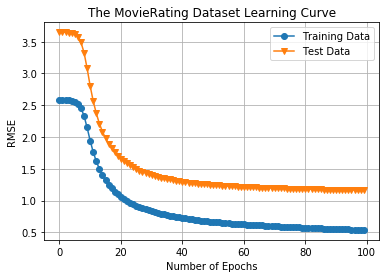

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    #file_path = "data/ml-100k/ratings.csv"
    pmf = PMF()
    pmf.set_params({"num_feat": 30, "epsilon": 1, "_lambda1": 0.1,"_lambda2": 0.2, "momentum": 0.8, "maxepoch": 100, "num_batches": 10,
                    "batch_size": 1000})
    print('The number of Latent Factors:',pmf.num_feat, 'The lambda for User:',pmf._lambda1,'The lambda for Movie:',pmf._lambda2)
    pmf.fit(train, test)
    print('RMSE for Train',pmf.rmse_train[-1])
    print('RMSE for Test',pmf.rmse_test[-1])
    # Check performance by plotting train and test errors
    plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
    plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
    plt.title('The MovieRating Dataset Learning Curve')
    plt.xlabel('Number of Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()

# pred_rating matrix

In [17]:
a=np.dot(pmf.w_User,pmf.w_Movie.T)
pred_matrix_final=a[:-1,]
np.shape(pred_matrix_final)

(610, 9724)

In [18]:
### train and test data transformation to 610*9724
R_test=np.zeros((610,9724))
R_train=np.zeros((610,9724))

# train data transformation
for i in range(0,train.shape[0]):
    user=train[i,0].astype(int)
    movie=train[i,1].astype(int)
    rating=train[i,2]
    R_train[user-1,movie-1]=rating
    
# test data transformation
for i in range(0,test.shape[0]):
    user=test[i,0].astype(int)
    movie=test[i,1].astype(int)
    rating=test[i,2]
    R_test[user-1,movie-1]=rating

## Step 3 Post-processing (SVD with KNN)

In [19]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

###########################################################################
###If we want to recommend by movie, do result['M'], else just use result['U']###
###########################################################################
result=pmf.w_Movie
Moviematrix = result
cosine_sim2 = cosine_similarity(Moviematrix, Moviematrix)

In [20]:
def get_recommendations(idx, cosine_sim=cosine_sim2):

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    #sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the indices of the sorted similar movies
    return movie_indices

In [21]:
R_predict = np.zeros(shape=(610,9724)) # the predict matrix

In [22]:
for i in range(610):
    for j in range(9724):
        if R_test[i,j] != 0:
            reclist = get_recommendations(j)
            for z in reclist:
                if R_train[i,z]!=0:
                    R_predict[i,j] = R_train[i,z]
                    continue

In [23]:
import math
print('The test rmse for the ajusted model is:',math.sqrt(sum((R_test-R_predict)**2)/test.shape[0]))

The test rmse for the ajusted model is: 1.3037332311383847


## Step 4 Evaluation

In [25]:
## fix number of features to be 30 and lambda2 be 0.2, change lambda1
lambdas = [0.05,0.10,0.15,0.2]
result_train = []
result_test = []
for value in lambdas:
    pmf = PMF()
    pmf.set_params({"num_feat": 30, "epsilon": 1, "_lambda1": value,"_lambda2": 0.2, "momentum": 0.8, "maxepoch": 100, "num_batches": 10,
                    "batch_size": 1000})
    pmf.fit(train, test)
    result_train.append(pmf.rmse_train)
    result_test.append(pmf.rmse_test)
result_train=np.array(result_train)
result_test=np.array(result_test)

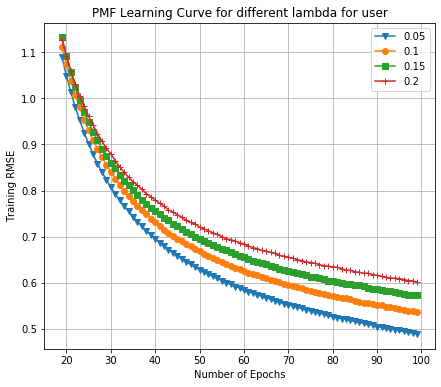

In [26]:
markers = ["v","o","s","+"]
plt.figure(figsize=(7,6))
for value in range(len(lambdas)):
    plt.plot(range(19,100), result_train[value,range(19,100)], marker=markers[value], label=lambdas[value])
plt.title('PMF Learning Curve for different lambda for user')
plt.xlabel('Number of Epochs')
plt.ylabel('Training RMSE')
plt.legend()
plt.grid()
plt.show()

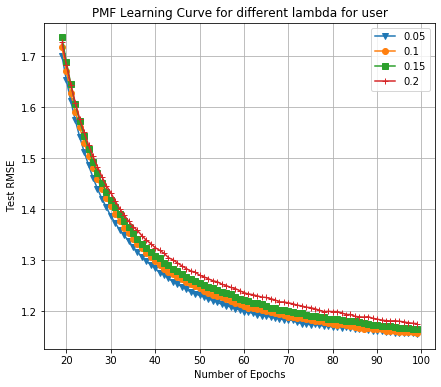

In [27]:
markers = ["v","o","s","+"]
plt.figure(figsize=(7,6))
for value in range(len(lambdas)):
    plt.plot(range(19,100), result_test[value,range(19,100)], marker=markers[value], label=lambdas[value])
plt.title('PMF Learning Curve for different lambda for user')
plt.xlabel('Number of Epochs')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid()
plt.show()

In [28]:
## fix number of features to be 30 and lambda1 be 0.1, change lambda2
lambdas = [0.05,0.10,0.15,0.2]
result_train = []
result_test = []
for value in lambdas:
    pmf = PMF()
    pmf.set_params({"num_feat": 30, "epsilon": 1, "_lambda1": 0.1,"_lambda2": value, "momentum": 0.8, "maxepoch": 100, "num_batches": 10,
                    "batch_size": 1000})
    pmf.fit(train, test)
    result_train.append(pmf.rmse_train)
    result_test.append(pmf.rmse_test)
result_train=np.array(result_train)
result_test=np.array(result_test)

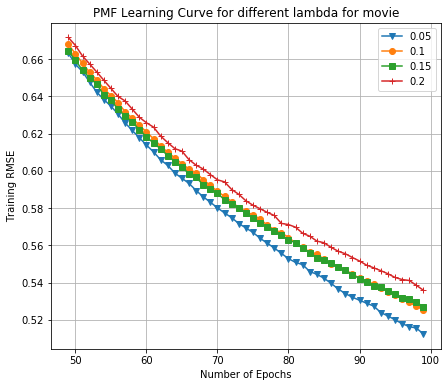

In [29]:
markers = ["v","o","s","+"]
plt.figure(figsize=(7,6))
for value in range(len(lambdas)):
    plt.plot(range(49,100), result_train[value,range(49,100)], marker=markers[value], label=lambdas[value])
plt.title('PMF Learning Curve for different lambda for movie')
plt.xlabel('Number of Epochs')
plt.ylabel('Training RMSE')
plt.legend()
plt.grid()
plt.show()

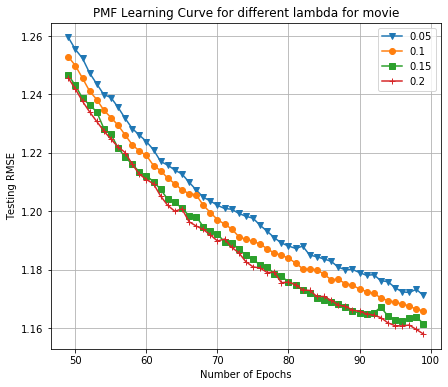

In [30]:
markers = ["v","o","s","+"]
plt.figure(figsize=(7,6))
for value in range(len(lambdas)):
    plt.plot(range(49,100), result_test[value,range(49,100)], marker=markers[value], label=lambdas[value])
plt.title('PMF Learning Curve for different lambda for movie')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing RMSE')
plt.legend()
plt.grid()
plt.show()

In [31]:
## fix lambda1 be 0.1 and lambda2 be 0.2, change number of features
lambdas = [10,20,30,40,50]
result_train = []
result_test = []
for value in lambdas:
    pmf = PMF()
    pmf.set_params({"num_feat": value, "epsilon": 1, "_lambda1": 0.1,"_lambda2": 0.2, "momentum": 0.8, "maxepoch": 100, "num_batches": 10,
                    "batch_size": 1000})
    pmf.fit(train, test)
    result_train.append(pmf.rmse_train)
    result_test.append(pmf.rmse_test)
result_train=np.array(result_train)
result_test=np.array(result_test)

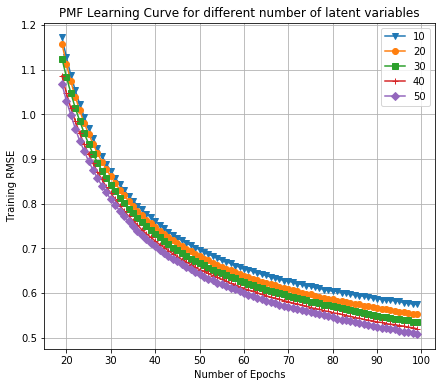

In [32]:
markers = ["v","o","s","+","D","x"]
plt.figure(figsize=(7,6))
for value in range(len(lambdas)):
    plt.plot(range(19,100), result_train[value,range(19,100)], marker=markers[value], label=lambdas[value])
plt.title('PMF Learning Curve for different number of latent variables')
plt.xlabel('Number of Epochs')
plt.ylabel('Training RMSE')
plt.legend()
plt.grid()
plt.show()

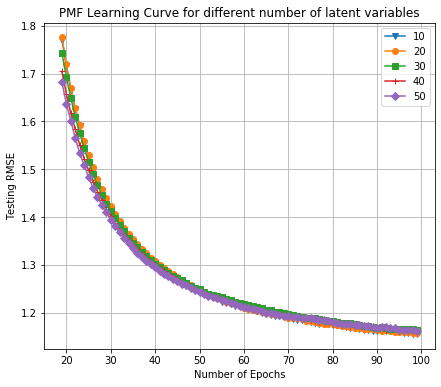

In [33]:
markers = ["v","o","s","+","D","x"]
plt.figure(figsize=(7,6))
for value in range(len(lambdas)):
    plt.plot(range(19,100), result_test[value,range(19,100)], marker=markers[value], label=lambdas[value])
plt.title('PMF Learning Curve for different number of latent variables')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing RMSE')
plt.legend()
plt.grid()
plt.show()